# Train Gaussian Mixture Regression

In [1]:
using AutomotiveDrivingModels
using RandomForestBehaviors

  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:7
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:9
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21


# Parameters

In [2]:
include(Pkg.dir("AutomotiveDrivingModels", "scripts", "extract_params.jl"))
nothing

In [3]:
dset_filepath_modifier = "_following" # _freeflow, _following, _lanechange

"_following"

In [4]:
dset = JLD.load(joinpath(EVALUATION_DIR, "dataset2" * dset_filepath_modifier * ".jld"),
                "model_training_data")::ModelTrainingData2
runlogs_original = load_runlogs(dset)
streetnets = load_streetnets(runlogs_original)

fold = 1
cv_split_outer = get_fold_assignment_across_drives(dset, N_FOLDS)
cv_split_inner = drop_fold!(deepcopy(cv_split_outer), fold)
@assert(cv_split_inner.nfolds > 0)

ntraces = length(cv_split_outer.seg_assignment);

## Optimize Hyperparams

In [5]:
train_def = BehaviorTrainDefinition(
                                    BehaviorTrainDefinition(
                                             GMR_TrainParams(
                                                 indicators=INDICATOR_SET2,
                                                 max_n_indicators=5,
                                                 fraction_test=0.2,
                                                 min_covar=1e-5,
                                                 n_components=10,
                                                 n_PCA_features=0,
                                                 ),
                                             [
                                                 BehaviorParameter(:n_components, [2,5,10], 1),
                                                 BehaviorParameter(:n_PCA_features, [0,5,10], 1),
                                             ]))

preallocated_data = preallocate_learning_data(dset, train_def.trainparams)
print(train_def); sleep(0.1)

BehaviorTrainDefinition
GMR Train Params
	targets: (:f_des_angle,:f_accel)
	indicators: [:posFyaw,:posFt,:speed,:velBx,:velBy,:velFs,:velFt,:turnrate,:acc,:accFs,:accFt,:accBx,:accBy,:d_ml,:d_mr,:ttcr_ml,:ttcr_mr,:est_ttcr,:a_req_stayinlane,:n_lane_left,:n_lane_right,:has_lane_right,:has_lane_left,:curvature]
	n_components:     10
	max_n_indicators: 5
	n_PCA_features:   0
	min_covar:        1.0e-5

hyperparams:
	n_components:        [>2<, 5, 10]
	n_PCA_features:      [>0<, 5, 10]


In [6]:
# AutomotiveDrivingModels.optimize_hyperparams_cyclic_coordinate_ascent!(
#                     train_def, dset, preallocated_data, cv_split_inner)
# print(train_def); sleep(0.1)

## Train

In [7]:
GM = train(dset, preallocated_data, train_def.trainparams, fold, cv_split_outer, true);
print(GM)
sleep(0.1)

LoadError: LoadError: TypeError: Type{...} expression: expected Type{T}, got Function
while loading In[7], in expression starting on line 1

## Likelihood

In [8]:
arr_logl_train = Float64[]
arr_logl_test = Float64[]
for frameind in 1 : nrow(dset.dataframe)
    if trains_with_nona(GM)
        logl = calc_action_loglikelihood(GM, dset.dataframe_nona, frameind)
    else
        logl = calc_action_loglikelihood(GM, dset.dataframe, frameind)
    end
    
    if is_in_fold(fold, cv_split_outer.frame_assignment[frameind], true)
        push!(arr_logl_test, logl)
    else
        push!(arr_logl_train, logl)
    end
end

@printf("%10s  %10s  %10s  %10s\n", "min", "mean", "median", "max")
@printf("%10.4f  %10.4f  %10.4f  %10.4f\n", minimum(arr_logl_train), mean(arr_logl_train), median(arr_logl_train), maximum(arr_logl_train))
@printf("%10.4f  %10.4f  %10.4f  %10.4f\n", minimum(arr_logl_test), mean(arr_logl_test), median(arr_logl_test), maximum(arr_logl_test))

LoadError: LoadError: UndefVarError: GM not defined
while loading In[8], in expression starting on line 3

    .>(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:179
is ambiguous with: 
    .>(AbstractArray{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:330.
To fix, define 
    .>(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}})
before the new definition.
    .>(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:179
is ambiguous with: 
    .>(AbstractArray, Union{DataArrays.DataArray, DataArrays.PooledDataArray}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:285.
To fix, define 
    .>(Images.AbstractImageDirect, Union{DataArrays.DataArray, DataArrays.PooledDataArray})
before the new definition.
    .*(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:

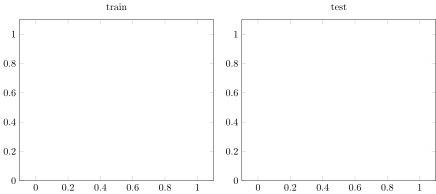

In [9]:
using PGFPlots
g = GroupPlot(2,1)
push!(g, Axis(Plots.Histogram(arr_logl_train, bins=50), ymin=0, title="train"))
push!(g, Axis(Plots.Histogram(arr_logl_test, bins=50), ymin=0, title="test"))
g

In [10]:
# Given:
#    data - a set of observed data points
#    model - a model that can be fitted to data points
#    n - the minimum number of data values required to fit the model
#    k - the maximum number of iterations allowed in the algorithm
#    t - a threshold value for determining when a data point fits a model
#    d - the number of close data values required to assert that a model fits well to data
# Return:
#    bestfit - model parameters which best fit the data (or nil if no good model is found)

using Distributions

data = arr_logl_test
m = length(data)
model = Normal
n = 10
k = 10
t = -4 # log likelihood
d = m*0.6 # 90% of the dataset
        
iterations = 0
bestfit = NaN
bestninliers = 0
besterr = Inf
bestdata = Float64[]
best_median_logl = NaN
while iterations < k
    
    maybeinliers = randperm(m)[1:n] # n randomly selected values from data
    maybemodel = fit_mle(model, data[maybeinliers]) # model parameters fitted to maybeinliers
    alsoinliers = Int[] # empty set
    
    for (i,v) in enumerate(data)
        if !in(i, maybeinliers)
            if logpdf(maybemodel, v) > t # point fits maybemodel with an error smaller than t
                push!(alsoinliers, i) # add point to alsoinliers
            end
        end
    end

    
    if length(alsoinliers) > d
        # this implies that we may have found a good model
        # now test how good it is
        fitdata = data[[maybeinliers; alsoinliers]]
        bettermodel = fit_mle(model, fitdata) # model parameters fitted to all points in maybeinliers and alsoinliers
        thiserr = sum(v->logpdf(bettermodel, v), fitdata)/length(fitdata) # a measure of how well model fits these points
        
        if thiserr < besterr
            bestfit = bettermodel
            besterr = thiserr
            bestninliers = length(fitdata)
            best_median_logl = median(fitdata)
            bestdata = fitdata
        end
    end
    iterations += 1
end
@printf("ninliers:  %5d (%5.2f percent)\n", bestninliers, 100*bestninliers/m)
@printf("noutliers: %5d (%5.2f percent)\n", m-bestninliers, 100*(1.0-bestninliers/m))
@printf("mean logl:   %10.6f\n", mean(bestfit))
@printf("median logl: %10.6f\n", best_median_logl)

Axis(Plots.Histogram(bestdata, bins=50), ymin=0, title="test inliers", width="14cm", height="4cm")

LoadError: LoadError: BoundsError: attempt to access 0-element Array{Int64,1}
  at index [1:10]
while loading In[10], in expression starting on line 27